
## Lecture 12:
#### Suppakorn Rakna `63070501061`

- What is the maximum quantum volume you can achieve using a simulated Athens device?
- What affect does changing the list of qubits have? 
- What affect does changing the optimization level have? 
- Can you do anything to improve the score?


In [1]:
from qiskit.ignis.verification.quantum_volume import qv_circuits
qubit_lists = [ [0,1],          # Qubits used to test QV 4
               [0,1,2],        # QV 8
               [0,1,2,3],      # QV 16
               [0,1,2,3,4],    # QV 32
               [0,1,2,3,4,5] ]  # QV 64
NTRIALS = 100  # number of circuits to generate for each qubit list
qv_qc_list, qv_qc_list_nomeas = qv_circuits(qubit_lists, NTRIALS)

<ipython-input-1-1d153f8493d7>:1: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.quantum_volume import qv_circuits


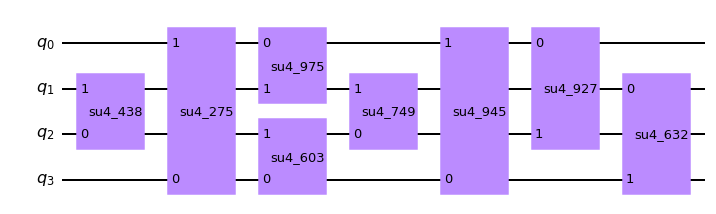

In [2]:
# .decompose() unrolls the circuit one level
qv_qc_list_nomeas[0][2].decompose().draw(output='mpl')

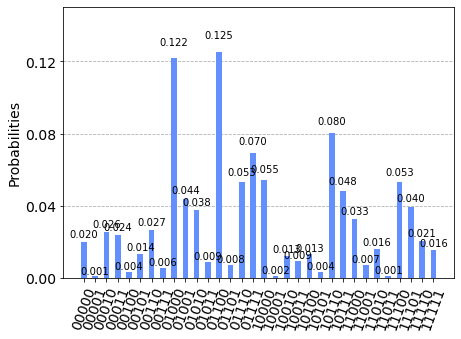

In [3]:
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram
sim = Aer.get_backend('aer_simulator')

TRIAL = 0
QUBIT_LIST_IDX = 3
example_qc = qv_qc_list_nomeas[TRIAL][QUBIT_LIST_IDX]
example_qc = transpile(example_qc, sim)
example_qc.save_statevector()  # this is an instruction to the simulator
example_counts = sim.run(example_qc).result().get_counts()
plot_histogram(example_counts)

In [4]:
def get_heavy_outputs(counts):
    """Extract heavy outputs from counts dict.
    Args:
        counts (dict): Output of `.get_counts()`
    Returns:
        list: All states with measurement probability greater
              than the mean.
    """
    # sort the keys of `counts` by value of counts.get(key)
    sorted_counts = sorted(counts.keys(), key=counts.get)
    # discard results with probability < median
    heavy_outputs = sorted_counts[len(sorted_counts)//2:]
    return heavy_outputs

print(get_heavy_outputs(example_counts))

['11110', '00011', '00010', '00110', '11000', '01010', '11101', '01001', '10111', '01110', '11100', '10000', '01111', '10110', '01000', '01100']


In [5]:
def check_threshold(nheavies, ncircuits, nshots):
    """Evaluate adjusted threshold inequality for quantum volume.
    Args:
        nheavies (int): Total number of heavy outputs measured from device
        ncircuits (int): Number of different square circuits run on device
        nshots (int): Number of shots per circuit
    Returns:
        Bool:
            True if heavy output probability is > 2/3 with 97% certainty,
            otherwise False
    """
    from numpy import sqrt
    numerator = nheavies - 2*sqrt(nheavies*(nshots-(nheavies/ncircuits)))
    return bool(numerator/(ncircuits*nshots) > 2/3)

In [6]:
def test_qv(device, qubits, ncircuits, nshots):
    """Try to achieve 2**len(qubits) quantum volume on device.
    Args:
        device (qiskit.providers.Backend): Device to test.
        qubits (list(int)): List of qubits to use for test.
        ncircuits (int): Number of unique circuits to generate
                         (should be >100).
        nshots (int): Number of shots per circuit.
    Returns:
        Bool
            True if device passes test, otherwise False.
    """
    # generate set of random circuits
    qv_qc, qv_qc_nomeas = qv_circuits([qubits], ncircuits)
    nheavies = 0  # number of measured heavy outputs

    def get_result(circuit, backend=None):
        if backend is None:  # use simulator
            backend = Aer.get_backend('aer_simulator')
            circuit.save_statevector()
            shots = None
            memory = None
        else:
            shots = nshots
            memory = True
        t_circuit = transpile(circuit, backend)
        # 'assemble' is just until mock backends take circuits in 'run'
        # pylint: disable=redefined-outer-name
        from qiskit import assemble
        job = backend.run(assemble(t_circuit,
                                   shots=shots,
                                   memory=memory))
        return job.result()

    for circuit in range(ncircuits):
        # simulate circuit
        counts = get_result(qv_qc_nomeas[circuit][0]).get_counts()
        # get heavy outputs from simulated results
        simulated_heavy_outputs = get_heavy_outputs(counts)
        # run circuit on device
        device_result = get_result(qv_qc[circuit][0], device)
        # record whether device result is in the heavy outputs
        for output in device_result.get_memory():
            if output in simulated_heavy_outputs:
                nheavies += 1

    # do statistical check to see if device passes test
    is_pass = check_threshold(nheavies, ncircuits, nshots)
    # calculate percentage of measurements that are heavy outputs
    pho = nheavies*100/(ncircuits * nshots)

    print(f"Quantum Volume: {2**len(qubits)}\n"
          f"Percentage Heavy Outputs: {pho:.1f}%\n"
          f"Passed?: {is_pass}\n")
    return is_pass

In [24]:
from qiskit.test.mock import FakeSantiago, FakeAthens

test_qv(FakeAthens(), [0,1,2,4], ncircuits=150, nshots=100)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/qiskit/ignis/verification/quantum_volume/circuits.py:67: DeprecationWarning: Using a qubit list to map a virtual circuit to a physical layout is deprecated and will be removed in a future release. Instead use ''qiskit.transpile' with the 'initial_layout' parameter
  warnings.warn("Using a qubit list to map a virtual circuit to "


Quantum Volume: 16
Percentage Heavy Outputs: 67.2%
Passed?: False



False

In [30]:
from qiskit.ignis.verification.quantum_volume import qv_circuits
qubit_lists = [ [0,1],          # Qubits used to test QV 4
               [0,1,2],        # QV 8
               [0,1,2,3],      # QV 16
               [0,1,2,3,4] ]    # QV 32
NCIRCUITS = 150  # number of circuits to generate for each qubit list
qv_qc_list, qv_qc_list_nomeas = qv_circuits(qubit_lists, NCIRCUITS)

In [31]:
from qiskit import Aer, transpile
sim = Aer.get_backend('aer_simulator')
ideal_results_list = []
print('Simulating trials:\n[', end="")
for trial in range(NCIRCUITS):
    print('#', end="")
    t_qc = transpile(qv_qc_list_nomeas[trial], sim)
    for qc in t_qc:
        qc.save_statevector()
    result = sim.run(t_qc).result()
    ideal_results_list.append(result)
print(']')
print('Done!')

Simulating trials:
[######################################################################################################################################################]
Done!


In [32]:
from qiskit.ignis.verification.quantum_volume import QVFitter
qv_fitter = QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results_list)

In [33]:
from qiskit.test.mock import FakeAthens
athens = FakeAthens()

In [38]:
device_results_list = []
print('Running trials:\n[', end="")
for trial in range(NCIRCUITS):
    print('#', end="")
    t_qc = transpile(qv_qc_list[trial], athens, optimization_level=1)
    from qiskit import assemble
    qobj = assemble(t_qc)
    result = athens.run(qobj).result()
    device_results_list.append(result)
print(']')
print('Done!')

Running trials:
[######################################################################################################################################################]
Done!


In [39]:
qv_fitter.add_data(device_results_list)

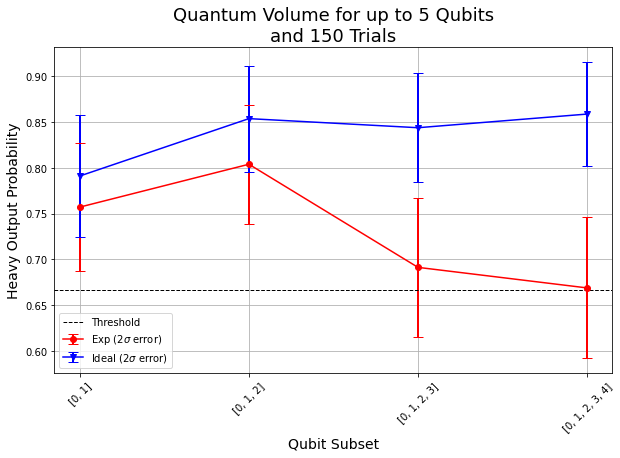

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = plt.gca()

qv_fitter.plot_qv_data(ax=ax, show_plt=False)

# Add title and label
ax.set_title(f"Quantum Volume for up to {len(qubit_lists[-1])} Qubits\n"
             f"and {NCIRCUITS} Trials", fontsize=18)

plt.show()